In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np

In [2]:
def plot_func(models, ylim_spearman=[0.53, 0.87], ylim_pearson=None):
    fig, axs = plt.subplots(2, 1, figsize=(8, 16))

    for x in models:
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names_labels = x[3]
        for p in pool:
            for (name, label) in json_names_labels:
                spearman, pearson = [], []
                std_spearman, std_pearson = [], []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))

                    std_1 = res["stdev_cosine_spearman_test"]
                    mean_1 = res["mean_cosine_spearman_test"]
                    std_spearman.append((mean_1-std_1, mean_1+std_1))
                    spearman.append(mean_1)

                    std_2 = res["stdev_cosine_pearson_test"]
                    mean_2 = res["mean_cosine_pearson_test"]
                    std_pearson.append((mean_2-std_2, mean_2+std_2))
                    pearson.append(mean_2)

                axs[0].plot(spearman, label=label)
                if "unsupervised" not in name:
                    axs[0].fill_between(
                        np.array(list(range(c))), 
                        np.array(std_spearman)[:,0], 
                        np.array(std_spearman)[:,1], 
                        alpha=0.15
                    )
                axs[0].set_xlabel("Index of used hidden state")
                axs[0].set_ylabel("Spearman correlation coefficient (test set)")
                axs[0].legend()
                if ylim_spearman is not None:
                    axs[0].set_ylim(ylim_spearman)

                axs[1].plot(pearson, label=label)
                if "unsupervised" not in name:
                    axs[1].fill_between(
                        np.array(list(range(c))), 
                        np.array(std_pearson)[:,0], 
                        np.array(std_pearson)[:,1], 
                        alpha=0.15
                    )
                axs[1].set_xlabel("Index of used hidden state")
                axs[1].set_ylabel("Pearson correlation coefficient (test set)")
                axs[1].legend()
                if ylim_pearson is not None:
                    axs[1].set_ylim(ylim_pearson)
                
def plot_func_unsupervised(models):
    fig, axs = plt.subplots(2, 1, figsize=(8, 16))

    for x in models:
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names = x[3]
        for p in pool:
            spearman, pearson = [], []
            spearman_std, pearson_std = [], []
            for name in json_names:
                spearman_tmp, pearson_tmp = [], []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))

                    mean_1 = res["mean_cosine_spearman_test"]
                    spearman_tmp.append(mean_1)

                    mean_2 = res["mean_cosine_pearson_test"]
                    pearson_tmp.append(mean_2)
                
                spearman.append(spearman_tmp)
                pearson.append(pearson_tmp)
                
            spearman = np.array(spearman)
            pearson = np.array(pearson)
            
            spearman_mean = spearman.mean(axis=0)
            pearson_mean = pearson.mean(axis=0)
            
            spearman_std = spearman.std(axis=0, ddof=1)
            pearson_std = pearson.std(axis=0, ddof=1)

            axs[0].plot(spearman_mean, label=f"{m} {p}")
            if "unsupervised" in name:
                axs[0].fill_between(
                    np.array(list(range(c))), 
                    spearman_mean - spearman_std,
                    spearman_mean + spearman_std, 
                    alpha=0.15
                )
            axs[0].set_xlabel("Index of finetuned hidden state")
            axs[0].set_ylabel("Spearman correlation coefficient (test set)")
            axs[0].legend()

            axs[1].plot(pearson_mean, label=f"{m} {p}")
            if "unsupervised" in name:
                axs[1].fill_between(
                    np.array(list(range(c))), 
                    pearson_mean - pearson_std,
                    pearson_mean + pearson_std, 
                    alpha=0.15
                )
            axs[1].set_xlabel("Index of hidden state")
            axs[1].set_ylabel("Pearson correlation coefficient (test set)")
            axs[1].legend()

# Finetuned

### Word Sim

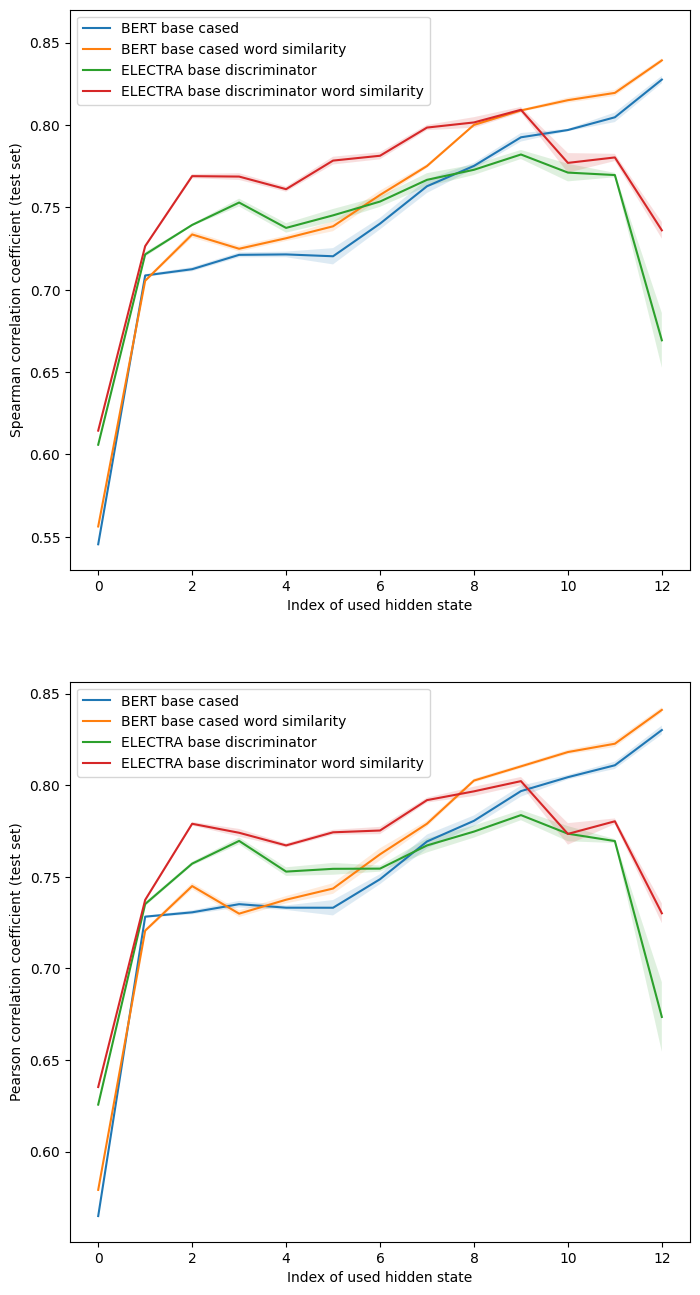

In [3]:
models = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results", "BERT base cased"),
            ("test_results_word_similarity", "BERT base cased word similarity")
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base discriminator"),
            ("test_results_word_similarity", "ELECTRA base discriminator word similarity")
         ]
    ),
    #("google-electra-base-generator", ["mean"], 13, 
    #     [
    #        ("test_results", "ELECTRA base generator"),
    #        ("test_results_word_similarity", "ELECTRA base generator word similarity")
    #     ]
    #)
]

plot_func(models)

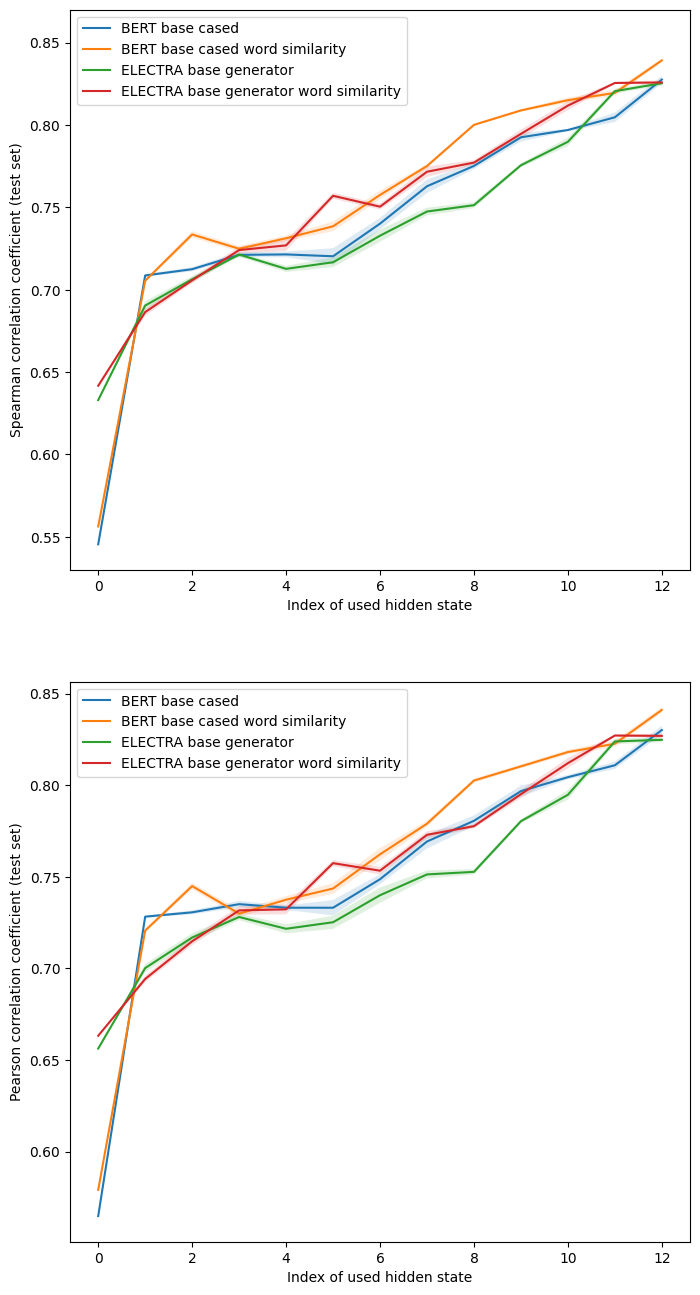

In [4]:
models = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results", "BERT base cased"),
            ("test_results_word_similarity", "BERT base cased word similarity")
         ]
    ),
    #("google-electra-base-discriminator", ["mean"], 13, 
    #     [
    #        ("test_results", "ELECTRA base discriminator"),
    #        ("test_results_word_similarity", "ELECTRA base discriminator word similarity")
    #     ]
    #),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base generator"),
            ("test_results_word_similarity", "ELECTRA base generator word similarity")
         ]
    )
]

plot_func(models)

### Standard

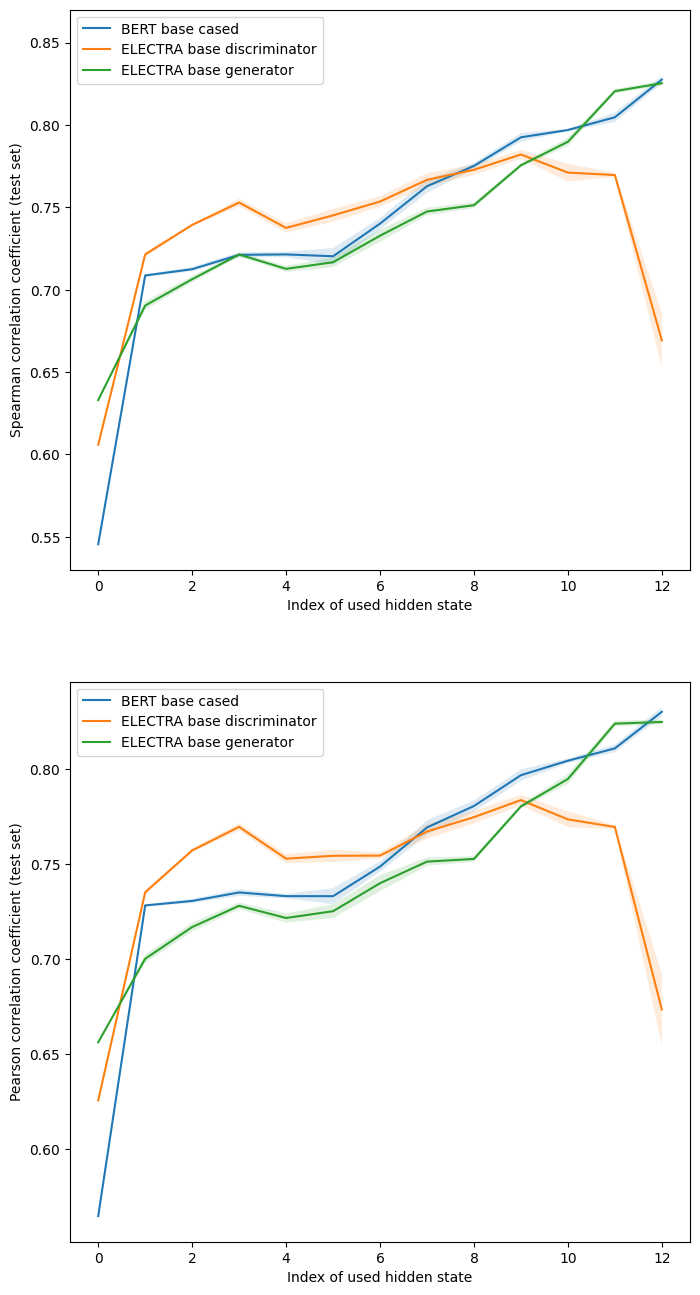

In [5]:
models = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results", "BERT base cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
        [
            ("test_results", "ELECTRA base generator"),
         ]
    )
]

plot_func(models)

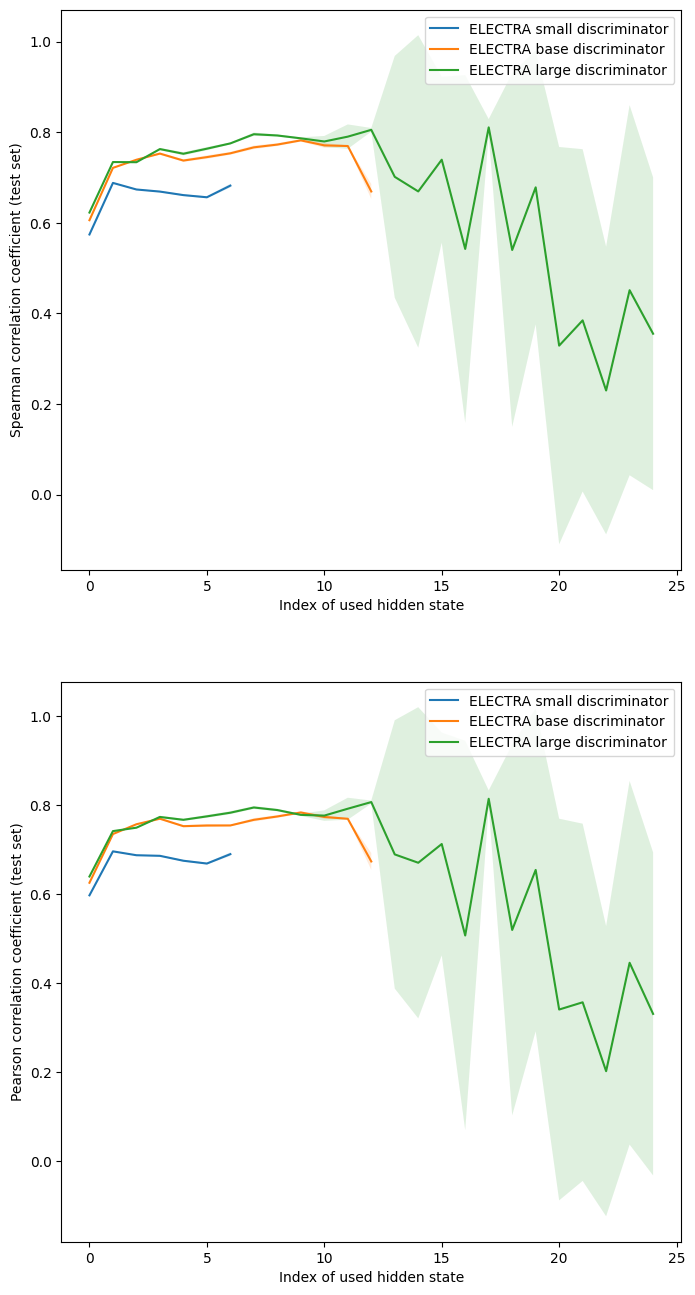

In [6]:
models = [
    ("google-electra-small-discriminator", ["mean"], 7,
         [
            ("test_results", "ELECTRA small discriminator"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13,
         [
            ("test_results", "ELECTRA base discriminator"),
         ]
    ),
    ("google-electra-large-discriminator", ["mean"], 25,
        [
            ("test_results", "ELECTRA large discriminator"),
         ]
    )
]

plot_func(models, ylim_spearman=None)

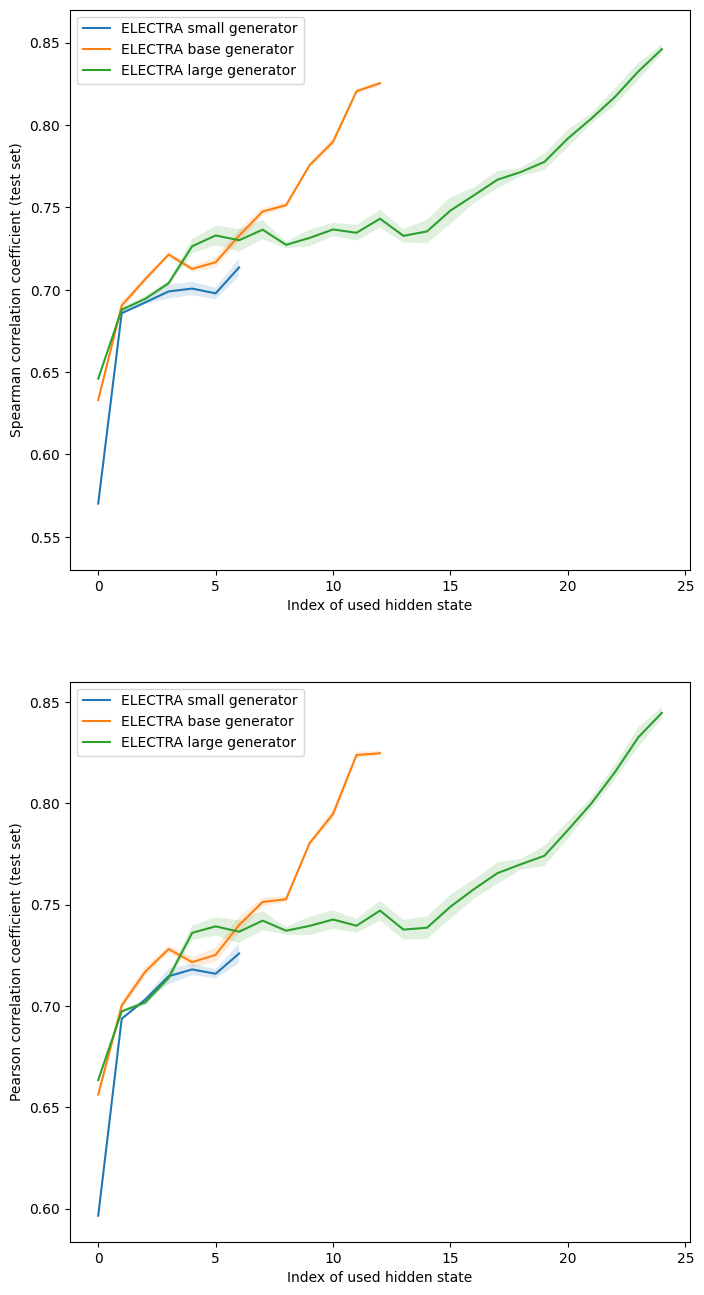

In [7]:
models = [
    ("google-electra-small-generator", ["mean"], 7,
         [
            ("test_results", "ELECTRA small generator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13,
         [
            ("test_results", "ELECTRA base generator"),
         ]
    ),
    ("google-electra-large-generator", ["mean"], 25,
        [
            ("test_results", "ELECTRA large generator"),
         ]
    )
]

plot_func(models)

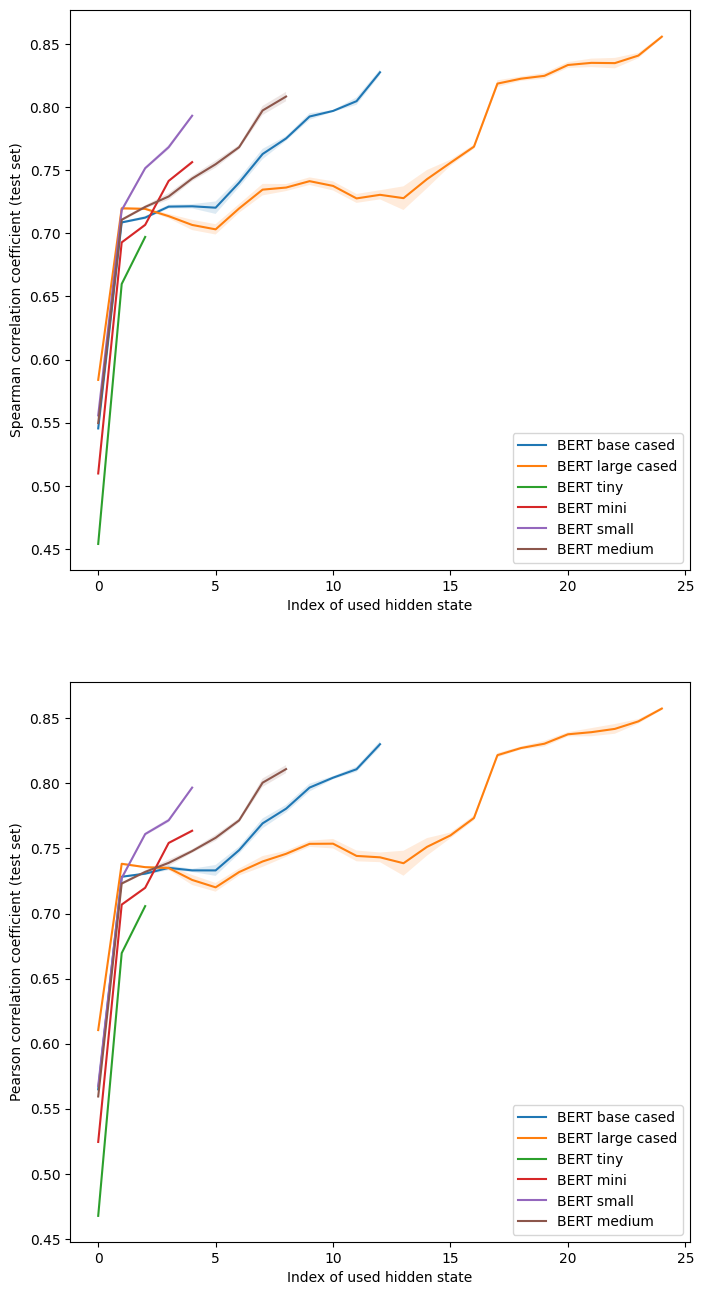

In [8]:
models = [
    
    ("bert-base-cased", ["mean"], 13,
         [
            ("test_results", "BERT base cased"),
         ]
    ),
    ("bert-large-cased", ["mean"], 25,
         [
            ("test_results", "BERT large cased"),
         ]
    ),
    ("google-bert_uncased_L-2_H-128_A-2", ["mean"], 3,
        [
            ("test_results", "BERT tiny"),
         ]
    ),
    ("google-bert_uncased_L-4_H-256_A-4", ["mean"], 5,
        [
            ("test_results", "BERT mini"),
         ]
    ),
    ("google-bert_uncased_L-4_H-512_A-8", ["mean"], 5,
        [
            ("test_results", "BERT small"),
         ]
    ),
    ("google-bert_uncased_L-8_H-512_A-8", ["mean"], 9,
        [
            ("test_results", "BERT medium"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

 17%|███████▌                                     | 1/6 [00:00<00:04,  1.05it/s]

[[  0.5454546   22.66521645]
 [  0.7086418   29.753088  ]
 [  0.71246436  36.84096146]
 [  0.72117256  43.92883301]
 [  0.72143417  51.01670456]
 [  0.720315    58.10457611]
 [  0.74012793  65.19245148]
 [  0.7628244   72.28031921]
 [  0.77517046  79.36819458]
 [  0.79254298  86.45606232]
 [  0.79696534  93.54393768]
 [  0.80469903 100.63180542]
 [  0.82758652 107.71968079]]


 33%|███████████████                              | 2/6 [00:01<00:02,  1.54it/s]

[[  0.58392141  30.22028732]
 [  0.71982534  42.81651306]
 [  0.7193792   55.41273499]
 [  0.71360946  68.00895691]
 [  0.70665102  80.60518646]
 [  0.70316282  93.20140839]
 [  0.71972382 105.79763031]
 [  0.73462191 118.39385223]
 [  0.73627373 130.99008179]
 [  0.74133147 143.58630371]
 [  0.73756962 156.18252563]
 [  0.72766885 168.77874756]
 [  0.73051993 181.37496948]
 [  0.72786878 193.97120667]
 [  0.74292283 206.56742859]
 [  0.75589897 219.16365051]
 [  0.76866224 231.75987244]
 [  0.81862519 244.35609436]
 [  0.82250154 256.95233154]
 [  0.82477568 269.54855347]
 [  0.83335199 282.14477539]
 [  0.83504758 294.74099731]
 [  0.83484194 307.33721924]
 [  0.84081508 319.93344116]
 [  0.85578181 332.52966309]]


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.07it/s]

[[ 0.54968077 15.89145565]
 [ 0.71074868 19.04384041]
 [ 0.720917   22.19622421]
 [ 0.72920575 25.34860802]
 [ 0.74341808 28.50099182]
 [ 0.75475449 31.65337563]
 [ 0.7682503  34.80575943]
 [ 0.79732927 37.95814514]
 [ 0.80837623 41.11052704]]


 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.55it/s]

[[ 0.5557744  15.89145565]
 [ 0.71834288 19.04384041]
 [ 0.75159783 22.19622421]
 [ 0.76824236 25.34860802]
 [ 0.793158   28.50099182]]


100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.76it/s]


[[0.4539383  3.97286391]
 [0.65987893 4.1711359 ]
 [0.6971409  4.36940813]]
[[ 0.50976421  7.94572783]
 [ 0.69282601  8.73548794]
 [ 0.70671888  9.52524757]
 [ 0.74153089 10.31500816]
 [ 0.75638359 11.1047678 ]]


 33%|███████████████                              | 1/3 [00:00<00:00,  2.49it/s]

[[0.57438838 3.97286391]
 [0.68820065 4.76262379]
 [0.67368476 5.5523839 ]
 [0.66905937 6.34214401]
 [0.66127781 7.13190413]
 [0.65651121 7.92166424]
 [0.68223441 8.71142387]]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.22it/s]

[[  0.60589048  23.83718491]
 [  0.72143944  30.92505646]
 [  0.73932921  38.01292801]
 [  0.75292955  45.10079956]
 [  0.73752965  52.18867111]
 [  0.74515201  59.27654266]
 [  0.75353326  66.36441803]
 [  0.7667178   73.45228577]
 [  0.77281701  80.54016113]
 [  0.78210537  87.62802887]
 [  0.77111688  94.71590424]
 [  0.76961924 101.8037796 ]
 [  0.66928765 108.89164734]]


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


[[6.22776781e-01 3.17829113e+01]
 [7.34262088e-01 4.43791351e+01]
 [7.33901457e-01 5.69753609e+01]
 [7.62886100e-01 6.95715866e+01]
 [7.52569211e-01 8.21678085e+01]
 [7.63733720e-01 9.47640305e+01]
 [7.75434642e-01 1.07360252e+02]
 [7.95677434e-01 1.19956482e+02]
 [7.92886112e-01 1.32552704e+02]
 [7.86585436e-01 1.45148926e+02]
 [7.79667433e-01 1.57745148e+02]
 [7.90325397e-01 1.70341370e+02]
 [8.05357438e-01 1.82937607e+02]
 [7.01602564e-01 1.95533829e+02]
 [6.69403917e-01 2.08130051e+02]
 [7.39434577e-01 2.20726273e+02]
 [5.42446888e-01 2.33322495e+02]
 [8.10827328e-01 2.45918716e+02]
 [5.40176422e-01 2.58514954e+02]
 [6.78412108e-01 2.71111176e+02]
 [3.29073976e-01 2.83707397e+02]
 [3.84832131e-01 2.96303619e+02]
 [2.30061043e-01 3.08899841e+02]
 [4.51390654e-01 3.21496063e+02]
 [3.55314188e-01 3.34092285e+02]]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.51it/s]

[[0.57012301 3.97286391]
 [0.6857675  4.76262379]
 [0.69225748 5.5523839 ]
 [0.69897879 6.34214401]
 [0.7006883  7.13190413]
 [0.6977973  7.92166424]
 [0.71355245 8.71142387]]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  3.73it/s]

[[ 0.63299263 23.83718491]
 [ 0.69038939 24.62694359]
 [ 0.70636191 25.41670418]
 [ 0.72135467 26.20646477]
 [ 0.71266944 26.99622345]
 [ 0.71667764 27.78598404]
 [ 0.73279997 28.57574463]
 [ 0.74747885 29.36550331]
 [ 0.75133121 30.1552639 ]
 [ 0.77556538 30.94502449]
 [ 0.78982275 31.73478317]
 [ 0.82054196 32.52454376]
 [ 0.82538407 33.31430435]]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]

[[ 0.64599835 31.7829113 ]
 [ 0.68784254 32.5726738 ]
 [ 0.69445451 33.36243057]
 [ 0.70397561 34.15219116]
 [ 0.72641264 34.94195175]
 [ 0.73295327 35.73171234]
 [ 0.73004941 36.52147293]
 [ 0.73644367 37.31123352]
 [ 0.72725983 38.1009903 ]
 [ 0.73145533 38.89075089]
 [ 0.73659261 39.68051147]
 [ 0.73457698 40.47027206]
 [ 0.74310816 41.26003265]
 [ 0.73268914 42.04979324]
 [ 0.73542486 42.83955383]
 [ 0.74806053 43.62931061]
 [ 0.75735871 44.4190712 ]
 [ 0.766805   45.20883179]
 [ 0.77148949 45.99859238]
 [ 0.77761255 46.78835297]
 [ 0.79183041 47.57811356]
 [ 0.80395447 48.36787033]
 [ 0.8170221  49.15763092]
 [ 0.83253581 49.94739151]
 [ 0.84606222 50.7371521 ]]


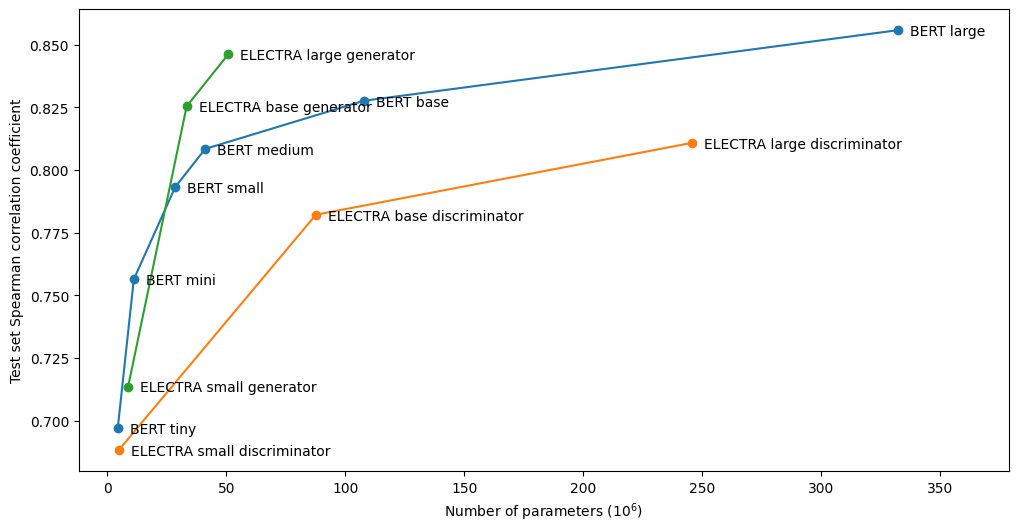

In [9]:
from transformers import AutoModel
from tqdm import tqdm
import torch

models = [
    [
        ("bert-base-cased", 13, "BERT base"),
        ("bert-large-cased", 25, "BERT large"),
        ("google-bert_uncased_L-8_H-512_A-8", 9, "BERT medium"),
        ("google-bert_uncased_L-4_H-512_A-8", 5,"BERT small"),
        ("google-bert_uncased_L-2_H-128_A-2", 3,"BERT tiny"),
        ("google-bert_uncased_L-4_H-256_A-4", 5,"BERT mini"),
    ],
    [
        ("google-electra-small-discriminator", 7, "ELECTRA small discriminator"),
        ("google-electra-base-discriminator", 13, "ELECTRA base discriminator"),
        ("google-electra-large-discriminator", 25, "ELECTRA large discriminator"),
    ],
    [
        ("google-electra-small-generator", 7, "ELECTRA small generator"),
        ("google-electra-base-generator", 13, "ELECTRA base generator"),
        ("google-electra-large-generator", 25, "ELECTRA large generator"),

    ]
]

def count_params(model, i):
    x = torch.tensor(0.)
    for p in model.embeddings.parameters():
        x += torch.prod(torch.tensor(p.shape))
    if i > 0:
        for p in model.encoder.layer[:i].parameters():
            x += torch.prod(torch.tensor(p.shape))
    return x/10**6

plt.figure(figsize=(12, 6))
for f in models:
    spearman, parameters = [], []
    for m in tqdm(f):
        means = []
        name = m[0] if "google" not in m[0] else m[0].replace("google-", "google/")
        model = AutoModel.from_pretrained(name)
        for i in range(m[1]):
            params = count_params(model, i)
            res = json.load(open(f"../output/{m[0]}/mean/{i}_to_{i+1}/test_results.json"))
            means.append([res["mean_cosine_spearman_test"], params])
        print(np.array(means))
        means = np.array(sorted(means, key=lambda x: x[0]))
        x, y = means[::-1, :][0]
        spearman.append(x)
        parameters.append(y)
        plt.annotate(m[2], (y+5, x-0.002))
        
    means_ = np.array([spearman, parameters]).T
    means_.sort(axis=0)
    
    plt.plot(means_[:,1], means_[:,0], "-o")
    plt.xlim([plt.xlim()[0], plt.xlim()[1]+10])
    #plt.ylim([plt.ylim()[0]-0.007, plt.ylim()[1]])
    plt.xlabel("Number of parameters ($10^6$)")
    plt.ylabel("Test set Spearman correlation coefficient")
plt.show()

In [ ]:
def count_params(model, i):
    x = torch.tensor(0.)
    for p in model.parameters():
        x += torch.prod(torch.tensor(p.shape))
    return x/10**6

count_params(model, 25)
model.config

# Korean

In [ ]:
models = [
    ("klue-bert-base", ["mean"], 13, 
        [
            ("test_results_kor_sts", "KLUE BERT base"),
         ]
    ),
    ("monologg-koelectra-base-v3-generator", ["mean"], 13, 
        [
            ("test_results_kor_sts", "KoELECTRA generator base"),
         ]
    ),
    ("monologg-koelectra-base-v3-discriminator", ["mean"], 13,
        [
            ("test_results_kor_sts", "KoELECTRA discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

# German

In [ ]:
models = [
    ("bert-base-german-cased", ["mean"], 13,
        [
            ("test_results_german_sts", "BERT base german cased"),
         ]
    ),
    ("deepset-gelectra-base-generator", ["mean"], 13, 
        [
            ("test_results_german_sts", "GELECTRA generator base"),
         ]
    ),
    ("deepset-gelectra-base", ["mean"], 13, 
        [
            ("test_results_german_sts", "GELECTRA discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

# Spanish

In [ ]:
models = [
    ("dccuchile-bert-base-spanish-wwm-cased", ["mean"], 13, 
        [
            ("test_results_spanish_sts", "BETO base"),
         ]
    ),
    ("mrm8488-electricidad-base-generator", ["mean"], 13, 
        [
            ("test_results_spanish_sts", "Electricidad generator base"),
         ]
    ),
    ("mrm8488-electricidad-base-discriminator", ["mean"], 13, 
        [
            ("test_results_spanish_sts", "Electricidad discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

# DAPT using MLM, then finetuned

In [ ]:
models = [
    ("bert-base-cased", ["mean"], 13, 
        [
            ("test_results", "BERT base cased"),
            ("test_results_bert-base-cased_model_epoch_9_mlm", "DAPT BERT base cased"),
         ]
    ),
    #("google-electra-base-generator", ["mean"], 13, 
    #    [
    #        ("test_results", "ELECTRA base generator"),
    #        ("test_results_google-electra-base-generator_model_epoch_9_mlm", "DAPT ELECTRA generator"),
    #     ]
    #),
    ("google-electra-base-discriminator", ["mean"], 13, 
        [
            ("test_results", "ELECTRA discriminator base"),
            ("test_results_google-electra-base-discriminator_model_epoch_9_mlm", "DAPT ELECTRA discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

In [ ]:
models = [
    ("bert-base-cased", ["mean"], 13, 
        [
            ("test_results", "BERT base cased"),
            ("test_results_bert-base-cased_model_epoch_9_mlm", "DAPT BERT base cased"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
        [
            ("test_results", "ELECTRA base generator"),
            ("test_results_google-electra-base-generator_model_epoch_9_mlm", "DAPT ELECTRA generator"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)